In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re
import string

import numpy as np

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import naive_bayes
from sklearn import linear_model

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.ensemble import VotingClassifier


import multiprocessing 
import gensim
from gensim.models import Word2Vec,Phrases

from keras.models import Model
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Dropout, Bidirectional,Concatenate, Embedding, Input 

# from aif360.metrics import DisparateImpactRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset

from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    true_negative_rate,
    selection_rate,
    demographic_parity_difference, 
    demographic_parity_ratio,
    equalized_odds_difference,
    equalized_odds_ratio
)
from fairlearn.preprocessing import CorrelationRemover


# pre processing for the ADMISSIONS files including some fairness columns such as marit

In [52]:
#table admission
df = pd.read_csv("ADMISSIONS.csv")
print("shape of dataframe admission:", df.shape)
df = df.drop(['EDOUTTIME','EDREGTIME','DISCHARGE_LOCATION','ADMISSION_LOCATION',
        'ADMITTIME','HAS_CHARTEVENTS_DATA', "DIAGNOSIS","ROW_ID","DISCHTIME","DEATHTIME"],axis = 1)

#table patients
df_Patients = pd.read_csv("PATIENTS.csv")
print("shape of dataframe patients:",df_Patients.shape)
df_Patients = df_Patients.drop(["DOB","DOD","DOD_HOSP","DOD_SSN", "ROW_ID"],axis = 1)

#table noteevents
df_note = pd.read_csv("NOTEEVENTS.csv")
print("shape of dataframe note:", df_note.shape)# because the previous data is too big, I extract a specific number of random rows.
df_note = df_note.drop(["ROW_ID","CHARTDATE","CHARTTIME","STORETIME","CGID"],axis = 1)#CGID is the ID of caregiver
condition_Nursing = df_note['CATEGORY'] == 'Nursing/other'# filter the rows which the catergory is nursing
df_note = df_note.loc[condition_Nursing]
print("shape of dataframe note after filtering:", df_note.shape)

#merge these three tables
df = df.merge(df_Patients, how='left',on = 'SUBJECT_ID')
df_merge = df_note.merge(df, how='left',on = ['SUBJECT_ID', 'HADM_ID'])
print("shape of merge dataframe:",df_merge.shape)
# repeated patients are not allowed
# print(df_merge.CATEGORY.value_counts())

unique_feature = 'SUBJECT_ID'
df_merge = df_merge.drop_duplicates(subset=unique_feature)# Remove duplicates based on the unique feature
print("shape of merge dataframe after conduct the unique process:",df_merge.shape)

shape of dataframe admission: (58976, 19)
shape of dataframe patients: (46520, 8)


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2521584644.py:13: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_note = pd.read_csv("NOTEEVENTS.csv")


shape of dataframe note: (2083180, 11)
shape of dataframe note after filtering: (822497, 6)
shape of merge dataframe: (822497, 15)
shape of merge dataframe after conduct the unique process: (30005, 15)


In [53]:
df_merge.columns

Index(['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'ISERROR', 'TEXT',
       'ADMISSION_TYPE', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'EXPIRE_FLAG'],
      dtype='object')

# some research on the note

In [54]:
#df_note.CATEGORY.value_counts()

pd.set_option('display.max_colwidth', None)# display the string completely instead of the truncated version

condition_Nursing = df_merge['CATEGORY'] == 'Nursing/other'
condition_Radiology= df_merge['CATEGORY'] == 'Radiology'
condition_ECG= df_merge['CATEGORY'] == 'ECG'
condition_Physician= df_merge['CATEGORY'] == 'Physician'
condition_Echo= df_merge['CATEGORY'] == 'Echo'
condition_Respiratory= df_merge['CATEGORY'] == 'Respiratory'

condition_discharge = df_merge['CATEGORY'] == 'Discharge summary'


condtion_death =  df_merge['HOSPITAL_EXPIRE_FLAG'] == 1#death
condition_live = df_merge['HOSPITAL_EXPIRE_FLAG'] == 0#alive

selectedrows_for_live = df_merge.loc[condition_live&condition_Nursing, ['TEXT']]
selectedrows_for_death = df_merge.loc[condtion_death&condition_Nursing, ['TEXT']]

#select rows for live and death to watch the traits for different category of the notes
# selectedrows_for_live.sample(n=10)
# selectedrows_for_death.sample(n=10)


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3273039381.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


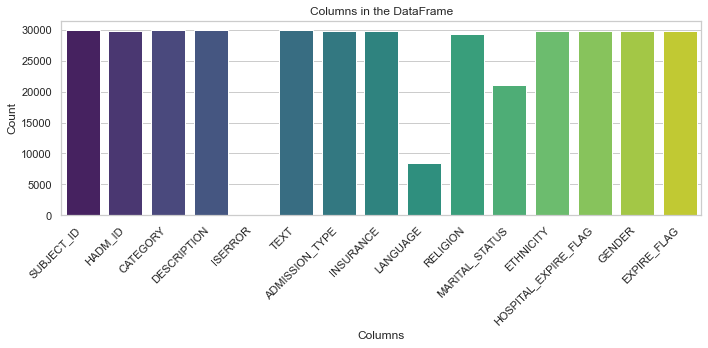

In [55]:
# Set the style for seaborn plots (optional but makes the visualizations more appealing)
sns.set(style="whitegrid")

# Plot the DataFrame columns
plt.figure(figsize=(10, 5))
sns.barplot(x=df_merge.columns, y=df_merge.count(), palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Columns in the DataFrame')
plt.tight_layout()
plt.show()


In [56]:
df_merge.HOSPITAL_EXPIRE_FLAG.value_counts()

0.0    26794
1.0     3026
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

continue-merge

In [57]:
#balance the number of labels
df_merge = df_merge[ df_merge['CATEGORY'] == 'Nursing/other']
positive = df_merge[df_merge['HOSPITAL_EXPIRE_FLAG'] == 1]
negative = df_merge[df_merge['HOSPITAL_EXPIRE_FLAG'] == 0]

positive = positive.sample(n=3000)
negative = negative.sample(n=3000)
df_merge = pd.concat([positive, negative])
df_merge = df_merge.sample(frac=1).reset_index(drop=True)#reset the index of rows

In [58]:
#if HOSPITAL_EXPIRE_FLAG is 1, it means this patient was dead within the given hospitalization

df_missing_value = df_merge.shape[0] - df_merge.count()
df_missing_value = pd.DataFrame(df_missing_value,columns = ["number of missing values"])
df_missing_value = df_missing_value.sort_values(by=['number of missing values'], ascending =False)
df_missing_value.style.background_gradient(axis=None)

,number of missing values
ISERROR,6000
LANGUAGE,4507
MARITAL_STATUS,1316
RELIGION,123
SUBJECT_ID,0
HADM_ID,0
CATEGORY,0
DESCRIPTION,0
TEXT,0
ADMISSION_TYPE,0


In [59]:
df_merge = df_merge.drop(['LANGUAGE','EXPIRE_FLAG','DESCRIPTION'],axis = 1)

#if iserror is 1 ,it indicates this wrong
df_merge = df_merge.drop(df_merge[df_merge['ISERROR'] == 1].index)
df_merge =  df_merge.dropna(subset=['HOSPITAL_EXPIRE_FLAG'])

visualization of un-processed data

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\409677387.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\chen\AppData\Local\Temp\ipykernel_2760\409677387.py:21: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\chen\AppData\Local\Temp\ipykernel_2760\409677387.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\chen\AppData\Local\Temp\ipykernel_2760\409677387.py:36: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\chen\AppData\Local\Temp\ipykernel_2760\409677387.py:49: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


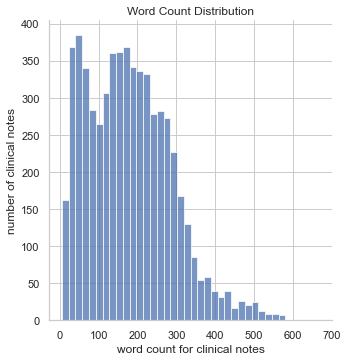

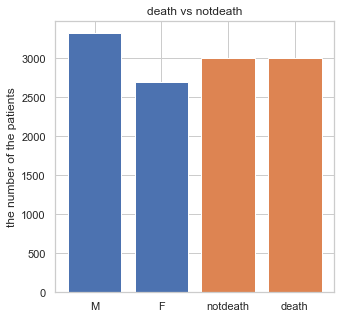

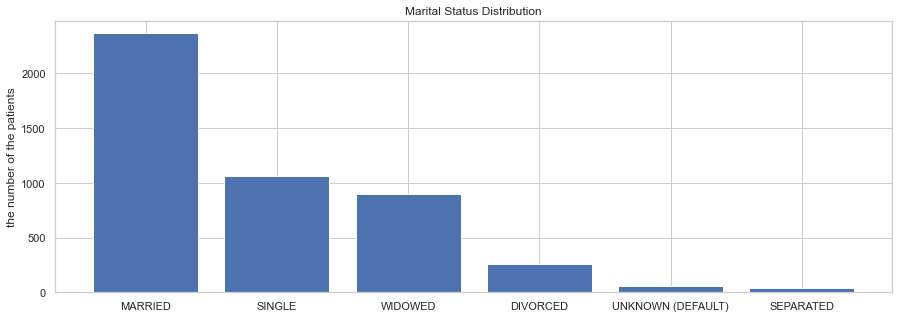

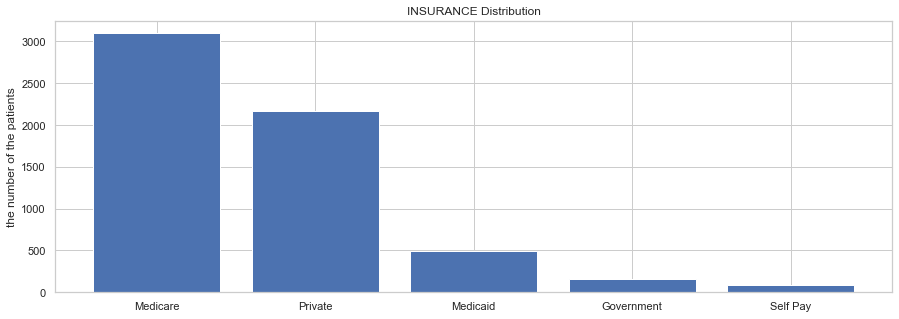

In [60]:
wordcount_list = df_merge.TEXT.apply(lambda x: len(x.split(" "))) 
sns.displot(wordcount_list)
plt.title("Word Count Distribution")
plt.xlabel("word count for clinical notes")
plt.ylabel("number of clinical notes")
plt.show()

# subject is unique to a patient, and hadm_id is unique to the admission of a patient, is_error can identify whether this note is wrong.
#df_sample.head(1)

#print(df_sample.TEXT[500])
# import re
# titles = re.findall(r'(\w+):\s',df.TEXT[1])

x=np.array(df_merge.GENDER.value_counts().index)
y = np.array(df_merge.GENDER.value_counts())
plt.figure(figsize = (5,5) )
plt.bar(x,y)
plt.title("GENDER Distribution")
plt.ylabel("the number of the patients")
plt.show()

x=np.array(["notdeath","death"])
y = np.array(df_merge.HOSPITAL_EXPIRE_FLAG.value_counts())
plt.bar(x,y)
plt.title("death vs notdeath")
plt.ylabel("the number of the patients")
plt.show()

x=np.array(df_merge.MARITAL_STATUS.value_counts().index)
y = np.array(df_merge.MARITAL_STATUS.value_counts())
plt.figure(figsize = (15,5) )
plt.bar(x,y)
plt.title("Marital Status Distribution")
plt.ylabel("the number of the patients")
plt.show()

# df_language = pd.DataFrame(df.RELIGION.value_counts())
# df_language = df_language.rename(columns = {"RELIGION":"NumPatients"})
# df_language = df_language.sort_values(by=['NumPatients'], ascending =False)
# df_language.style.background_gradient(axis=None)

x=np.array(df_merge.INSURANCE.value_counts().index)
y = np.array(df_merge.INSURANCE.value_counts())
plt.figure(figsize = (15,5) )
plt.bar(x,y)
plt.title("INSURANCE Distribution")
plt.ylabel("the number of the patients")
plt.show()

WHITE                                         4077
UNKNOWN/NOT SPECIFIED                          853
BLACK/AFRICAN AMERICAN                         426
ASIAN                                          177
HISPANIC OR LATINO                             146
OTHER                                          141
PATIENT DECLINED TO ANSWER                      59
UNABLE TO OBTAIN                                44
MULTI RACE ETHNICITY                            11
ASIAN - CHINESE                                 11
BLACK/CAPE VERDEAN                              11
HISPANIC/LATINO - PUERTO RICAN                   9
WHITE - RUSSIAN                                  6
AMERICAN INDIAN/ALASKA NATIVE                    6
WHITE - OTHER EUROPEAN                           4
ASIAN - VIETNAMESE                               3
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER        2
BLACK/HAITIAN                                    2
ASIAN - ASIAN INDIAN                             2
HISPANIC/LATINO - DOMINICAN    

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3053570257.py:69: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


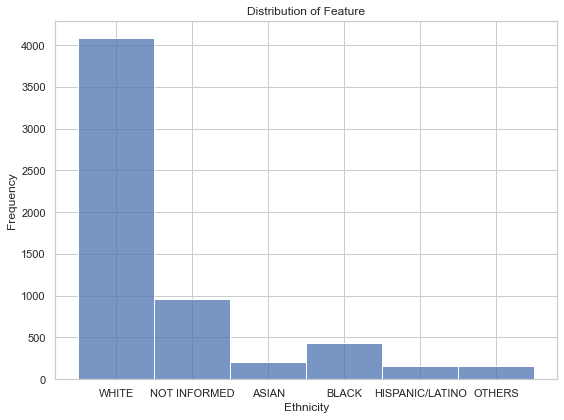

In [61]:
mapper_target={
    '0.0':0,
    '1.0':1
}


#map the entnicity
mapper_ethnicity={
    'WHITE':'WHITE',
    'BLACK/AFRICAN AMERICAN':'BLACK',
    'UNKNOWN/NOT SPECIFIED':'NOT INFORMED',
    'HISPANIC OR LATINO':'HISPANIC/LATINO',
    'OTHER':'OTHERS',
    'ASIAN':'ASIAN',
    'UNABLE TO OBTAIN':'NOT INFORMED',
    'PATIENT DECLINED TO ANSWER':'NOT INFORMED',
    'ASIAN - CHINESE':'ASIAN',
    'HISPANIC/LATINO - PUERTO RICAN':'HISPANIC/LATINO',
    'BLACK/CAPE VERDEAN':'BLACK',
    'WHITE - RUSSIAN':'WHITE',
    'MULTI RACE ETHNICITY':'OTHERS',
    'BLACK/HAITIAN':'BLACK',
    'ASIAN - ASIAN INDIAN':'ASIAN',
    'WHITE - OTHER EUROPEAN':'WHITE',
    'HISPANIC/LATINO - DOMINICAN':'HISPANIC/LATINO',
    'PORTUGUESE':'HISPANIC/LATINO',
    'WHITE - BRAZILIAN':'WHITE',
    'ASIAN - VIETNAMESE':'ASIAN',
    'AMERICAN INDIAN/ALASKA NATIVE':'ASIAN',
    'BLACK/AFRICAN':'BLACK',
    'MIDDLE EASTERN':'WHITE',
    'HISPANIC/LATINO - GUATEMALAN':'HISPANIC/LATINO',
    'WHITE - EASTERN EUROPEAN':'WHITE',
    'ASIAN - FILIPINO':'ASIAN',
    'HISPANIC/LATINO - CUBAN':'HISPANIC/LATINO',
    'HISPANIC/LATINO - SALVADORAN':'HISPANIC/LATINO',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':'OTHERS',
    'ASIAN - OTHER':'ASIAN',
    'ASIAN - CAMBODIAN':'ASIAN',
    'ASIAN - KOREAN':'ASIAN',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)':'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN':'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLOMBIAN':'HISPANIC/LATINO',
    'CARIBBEAN ISLAND':'BLACK',
    'SOUTH AMERICAN':'OTHERS',
    'ASIAN - JAPANESE':'ASIAN',
    'ASIAN - THAI':'ASIAN',
    'HISPANIC/LATINO - HONDURAN':'HISPANIC/LATINO',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':'ASIAN'
}



print(df_merge.ETHNICITY.value_counts(), "\n")
print(df_merge.MARITAL_STATUS.value_counts(), "\n")
print(df_merge.INSURANCE.value_counts(), "\n")
print(df_merge.ADMISSION_TYPE.value_counts())

df_merge['HOSPITAL_EXPIRE_FLAG'] = df_merge['HOSPITAL_EXPIRE_FLAG'].replace(mapper_target)
df_merge['ETHNICITY'] = df_merge['ETHNICITY'].replace(mapper_ethnicity)

plt.figure(figsize=(8, 6))
sns.histplot(df_merge['ETHNICITY'], bins=20)
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.title('Distribution of Feature')
plt.grid(True)
plt.tight_layout() 
plt.show()


def one_hot(df_merge):
    df_merge['HOSPITAL_EXPIRE_FLAG'] = df_merge['HOSPITAL_EXPIRE_FLAG'].replace(mapper_target)
    df_merge['ETHNICITY'] = df_merge['ETHNICITY'].replace(mapper_ethnicity)

    one_hot = pd.get_dummies(df_merge['MARITAL_STATUS'], dummy_na = True)
    one_hot['UNKNOWN (DEFAULT)'] = one_hot['UNKNOWN (DEFAULT)'] + one_hot.iloc[:,one_hot.shape[1] - 1]# Unknow value can also be the missing values(NaN)
    one_hot = one_hot.drop(one_hot.columns[one_hot.shape[1] - 1], axis=1)
    df_merge = pd.concat([df_merge, one_hot], axis=1)

    one_hot = pd.get_dummies(df_merge['INSURANCE'],prefix='INSURANCE', dummy_na = True)
    df_merge = pd.concat([df_merge, one_hot], axis=1)

    one_hot = pd.get_dummies(df_merge['ADMISSION_TYPE'],prefix='ADMISSION_TYPE', dummy_na = True)
    df_merge = pd.concat([df_merge, one_hot], axis=1)
    return df_merge
    
df_merge = one_hot(df_merge)



In [62]:
# gender = df_merge['GENDER']
# gender = gender.replace(mapper_g)
# plt.figure(figsize=(8, 6))
# sns.histplot(gender, bins=20)
# plt.xlabel('Feature Values')
# plt.ylabel('Frequency')
# plt.title('Distribution of Feature')
# plt.grid(True)
# plt.show()

# text preprocessing

In [63]:
def text_preprocessing1(x):# remove all of the special patterns
    x = " ".join(x.split())# delete the extra white space\
    x = re.sub(r'\[\*\*.*?\*\*\]', '', x)# drop all of the pattern [**blablabla**]
    x = re.sub(r'(\d+)+(\.|\))', '', x)# remove all of the serialization
    x = re.sub(r'(\*|\?|\#|\-)+', '', x)# remove all of the special characters
    #key_value_strip =(x.split(":"))# remove all of the small titles
    #print( key_value_strip)
    #x = re.sub(r'([A-Za-z]+):', '', x)
    
    # remove all of the time like 4:30
    #80-year-old-man use " " to spilt each of the words instead of 80yearoldman
    # how to process mg p.o. q.d. 
    #unit of measurement
    return x
  

def word_pos(word):# return the corresponding type of word based on the grammatical category
    #tagged_word = nltk.pos_tag(word)
    if word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('R'):
        return wordnet.ADV
    elif word.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # default to noun if POS tag is not recognized
      
def text_preprocessing2(x):
    x =  x.lower()
    symbol_pattern = r'[^a-zA-Z0-9\s]'  
    # Remove symbols
    x = re.sub(symbol_pattern, '', x)# symbols like %?
    STOPWORDS = set(stopwords.words('english')) #remove stopwords
    x =  " ".join([word for word in str(x).split() if word not in STOPWORDS])
    lemmatizer = WordNetLemmatizer()#
    x = " ".join([lemmatizer.lemmatize(word, word_pos(tagged_word)) for word,tagged_word in nltk.pos_tag(x.split())])#lemmatization
    return x

#encapsulate the all of the pre-processed methods
def text_processing(df_merge):
    df_merge_processed = df_merge
    df_merge_processed.TEXT = df_merge.TEXT.apply((lambda x: text_preprocessing1(x)))
    df_merge_processed.TEXT =df_merge.TEXT.apply((lambda x: text_preprocessing2(x)))
    return df_merge_processed
    
df_merge_processed = text_processing(df_merge)
df_merge_processed = df_merge_processed.reset_index(drop=True)    

cnt = Counter()
for text in df_merge_processed.TEXT:
    for word in text.split():
        cnt[word] += 1
        
print(cnt.most_common(100))



[('pt', 19748), ('note', 5917), ('resp', 4031), ('give', 3895), ('neuro', 3430), ('plan', 3398), ('family', 3368), ('hr', 3312), ('clear', 3291), ('w', 3179), ('bp', 3109), ('pain', 3010), ('remain', 2973), ('continue', 2960), ('place', 2691), ('care', 2647), ('abd', 2606), ('monitor', 2558), ('2', 2506), ('cont', 2492), ('follow', 2470), ('cv', 2410), ('see', 2399), ('b', 2395), ('time', 2346), ('iv', 2316), ('stable', 2302), ('start', 2294), ('soft', 2259), ('urine', 2234), ('well', 2213), ('gtt', 2208), ('skin', 2206), ('change', 2203), ('per', 2186), ('gi', 2138), ('sat', 2030), ('increase', 1991), ('infant', 1953), ('today', 1937), ('foley', 1894), ('receive', 1876), ('intact', 1872), ('x', 1864), ('gu', 1864), ('l', 1839), ('status', 1788), ('good', 1769), ('wean', 1750), ('support', 1744), ('sbp', 1734), ('blood', 1682), ('low', 1675), ('need', 1659), ('1', 1652), ('lung', 1648), ('drain', 1624), ('sound', 1620), ('dr', 1618), ('stool', 1609), ('vent', 1587), ('ct', 1560), ('po'

# Feature Extraction

TF-IDF

In [64]:
from sklearn import decomposition
def get_tfidf_features(df_merge_processed):
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit_transform(df_merge_processed.TEXT)
    tfidf =  tfidf_vect.transform(df_merge_processed.TEXT)
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect.get_feature_names_out())#convert the vector into dataframe
   
    #dimensionality reduction
    pca = decomposition.PCA(n_components=100)
    pca.fit(tfidf_df)
    tfidf_df_pca = pca.transform(tfidf_df)
    tfidf_df_pca = pd.DataFrame(tfidf_df_pca)  
    
    df_tfidf_merge = pd.concat([df_merge_processed, tfidf_df_pca], axis=1)
    return df_tfidf_merge

df_tfidf_merge = get_tfidf_features(df_merge_processed)
df_tfidf_merge.columns = df_tfidf_merge.columns.astype(str)

In [65]:
df_tfidf_merge

,SUBJECT_ID,HADM_ID,CATEGORY,ISERROR,TEXT,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,90,91,92,93,94,95,96,97,98,99
0,30841,141572.0,Nursing/other,NaN,neo attend boy ga6 wk bw3495gm admit nicu due respiratory distress palor mat hx 26 yr g2 p1 negab neg hepbsag neg rpr nr rub im gb rx x 12 hr ptd spon labor mat fever srom 2 hr ptd clear fluid ob report fht wnl vag delivery infant loose nuchal cord report vigorous cry apgars develop significant grunting neo call 2025 minute delivery infant dr pale pink undertone increase retraction grunt flaringbreath sound equal bilat cv exam hr100 apparent murmur exam bulb suction infant little return heent abd gu back extrem appeared appropriate dr neuro alert cry respr distress nl tone nl posture responsive gag upon adm nicu t2 hr 120 spo2 100 r68 bp6328mean glu screen wt 3495 gm hc 35cm l20 generally pale respiratory distress active alert copious secretion obtain sp suction catheter hypopharyngeal area stomach color improve pinkness grunting retraction wob continue cxr reveal bilat haziness increase perihilar marking cw fluid ctr wnl evidence air leak remainder exam heent af soft flat nc mild mold eye red reflex bilat ear nose mouth appear wnl neck mass sinuses clavicle wnl palpation chest respr distress note bsbilat air entry improve sp suction catheter b clear respr distress improve first hour cv gr 1 systolic murmur low parasternal region c tr nl heart sound s1 pulse reg palpable reg rhythm perfusion improve within first minute adm abd soft nondistended nontender mass hs megaly gu nl male back tiny tuft hair low sacral region anus patent extrem appear wnl skin petechia upper extremity face likely associate delivery neuro alert spon movement nl tone strength reflex cry plan ft male respr distress sp delivery improve suction infant transition mat gb mother rx 12 hr ptd risk factor besides gbs infant monitor per routine care infant resolve respiratory distress within 4 hr able feed po appear healthy transfer nbm continue routine newborn care pt attend examined delivery upon admission nicu discuss plan nicu team also speak parent dr status plan infant,NEWBORN,Private,NOT SPECIFIED,NaN,WHITE,...,-0.013352,-0.007135,0.010318,-0.035012,-0.027217,0.024735,-0.009333,0.045351,0.015789,-0.079216
1,13461,170608.0,Nursing/other,NaN,neonatologynnp progress note procedure intubation indication rds infant warm oxymetry cardiac monitoring place supine position use 0 laryngoscope 0 ett insert bbs cl tap 8 cm marker chest xray progress confirm placement,NEWBORN,Private,UNOBTAINABLE,NaN,NOT INFORMED,...,0.046123,0.004655,0.013461,0.029519,0.029672,0.019911,-0.008937,0.011263,-0.002306,-0.021946
2,24152,122642.0,Nursing/other,NaN,pt initially aox3 tolerate bipap family bedside pt receive mso4 x2 total 2mg increase agitation pt pull face mask thrash around bed face mask change nrb pt sat 5375 pt deny increase sob obviously dyspneic pt electively intubated pt consent give etomidate succ originally sedate propofol 1mg mso4 2mg ativan bolus give sbp decrease 60 receive 1l fluid bolus mod effect hr 60130s go excellerated junctional rhythm return srst ekg obtain dopamine start dt peripheral access aline rij obtain dopamine change neo 20mcgkgmin tmax 102po pan cx pr aspirin give x temp 4po current vent setting pcv400x41x8o sat 9698 see carevue current abgs l coarse diminish base initially suction large amts pink frothy sputum abdomen soft nondistended hypo b stool noc poor uop 2030cchr amberbloodtinged urine cx send follow ckmbs,EMERGENCY,Medicare,CATHOLIC,MARRIED,NOT INFORMED,...,-0.002041,-0.012234,0.004359,0.013989,-0.011538,-0.036352,-0.005241,-0.050296,-0.046558,0.061914
3,29461,147295.0,Nursing/other,NaN,sunday 7a7p npn ro neuro aox appropriate pleasant cooperative nursing care mae follow command po percocet incisional pain effect nicotine patch place ambulate hall physical therapy today multiple family visit today cv nsrst 90100s ectopy note sbp tolerate dose po metoprolol epicardial wire 

word2vec

In [66]:
def read_text(row, name):
    return  gensim.utils.simple_preprocess(str(row[name]).encode('utf-8'))


def build_word2vec_model(df_merge_processed):
    all_notes = []
    for inxdex, row in df_merge_processed.iterrows():
        all_notes.append(read_text(row,"TEXT"))
        
    #build the word2vec model    
    w2v_model = Word2Vec(vector_size =50,
                         min_count=2,
                         window=5,#the largest distance between current word and predicted word
                         sg = 0,#use the skip-gram algorithm 
                         alpha=0.03, 
                         min_alpha=0.0007, #learning rate
                         negative=20,
                        )
    w2v_model.build_vocab(all_notes)
    w2v_model.train(all_notes, total_examples=len(all_notes), epochs=5)#train the word2vec model
    return w2v_model

w2v_model = build_word2vec_model(df_merge_processed)


# the codes below is used to print all of the words stored in the vector pool
# for word in w2v_model.wv.key_to_index:
#     print(word)    
print("the number words converted to vectors ",len(w2v_model.wv.key_to_index))
# an instance that find the index of vector for word "okay"
word = "okay"
w2v_model.wv.most_similar(positive = word, topn = 5)

the number words converted to vectors  11606


[('unimpressive', 0.8093696236610413),
 ('isosorbide', 0.7707342505455017),
 ('swollow', 0.7677199840545654),
 ('renagel', 0.7636186480522156),
 ('cosult', 0.7629801630973816)]

In [67]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    # filter out words that are not present in the vocabulary.
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda note: list(map(keys.index, filter(filter_unknown, note)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized



input_length = 200#because the mean number of word per docment is nearly 100

def get_word2vec(input_length, w2v_model):
    all_notes = []
    for inxdex, row in df_merge_processed.iterrows():
        all_notes.append(read_text(row,"TEXT"))   
        
   #It is used to pad sequences to a specific length.
    X_pad = pad_sequences(
        sequences=vectorize_data(all_notes, vocab=w2v_model.wv.key_to_index),
        maxlen=input_length,
        padding='post')
    return X_pad

X_pad = get_word2vec(input_length, w2v_model)


X_vectors = []
for document in X_pad:
    document_vector = [w2v_model.wv.vectors[word_index] for word_index in document]
    X_vectors.append(document_vector)    
print("the number of vectors of a word: ",len(X_vectors[0][0]),
      "\nthe max length of words in a doc: ",len(X_vectors[0]),
     "\nthe number of documents: ", len(X_vectors))

Vectorize sentences... (done)
the number of vectors of a word:  50 
the max length of words in a doc:  200 
the number of documents:  6000


In [68]:
default_names = [f'F{i+1}' for i in range(len(X_pad[0]))]
df_X_pad = pd.DataFrame(X_pad, columns = default_names)
df_merge_w2v = pd.concat([df_merge_processed, df_X_pad], axis = 1 )

# Machine Learning

ensemble learning (ml + deep learning)

research on how combine the text and non-text features explainable machine learning?  done

pre processing to mitgate the fairness

increase the number of sample data done

increase the vector per sentence for word embedding 

add the race for the fairness metrics done

unique patient done

the formula fairlen metrics





dimonsion reduction concatente input for the next model

concatente dimonsion reduction input for the next model




In [69]:
input_df = df_merge_w2v.drop(['MARITAL_STATUS','RELIGION','ADMISSION_TYPE','INSURANCE','HADM_ID','SUBJECT_ID','CATEGORY','ISERROR','TEXT'],axis = 1)

y = input_df.HOSPITAL_EXPIRE_FLAG
x = input_df.drop('HOSPITAL_EXPIRE_FLAG',axis = 1)
y = y.astype(int)#convert the float type into integer
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y,test_size=0.2, random_state = 5)

F1_index = x_train.columns.get_loc('F1')
x_train_1 = x_train.iloc[:, F1_index:]#for deep learning
x_train_2 = x_train.iloc[:,:F1_index]

x_train_2 = x_train_2.drop(['ETHNICITY','GENDER'],axis = 1)

c_t_x_1, c_v_x_1, c_t_y, c_v_y = model_selection.train_test_split(x_train_1, y_train,test_size=0.2, random_state = 1)
c_t_x_2, c_v_x_2, _, _ = model_selection.train_test_split(x_train_2, y_train,test_size=0.2, random_state = 1)



In [70]:
def build_rnn_model(embedding_matrix: np.ndarray, input_length: int, shape1: int, shape2: int):
    
    input_1= Input( shape=(shape1))
    input_2 = Input(shape=(shape2))
    
    embedded_layer_input=Embedding(input_dim = embedding_matrix.shape[0],#how many words in the vocabulary
                                   output_dim = embedding_matrix.shape[1],#how many vectors per word                                  
                                   input_length = input_length,#the length of the words per row
                                   weights = [embedding_matrix],
                                   trainable=False)(input_1)
    
    
    
    LSTM_layer = Bidirectional(LSTM(128, recurrent_dropout=0.1))(embedded_layer_input)
    
    combined = Concatenate()([LSTM_layer, input_2])
    Dropout_layer_1 = Dropout(0.25)(combined)
    Dense_layer = Dense(64)(Dropout_layer_1)
    Droupout_layer_2 = Dropout(0.3)(Dense_layer)
    output_layer = Dense(1, activation='sigmoid')(Droupout_layer_2)
    model=Model([input_1, input_2], output_layer)
    return model



model = build_rnn_model(embedding_matrix = w2v_model.wv.vectors, input_length = input_length
                        ,shape1 = c_t_x_1.shape[1:][0], shape2 = c_t_x_2.shape[1:][0])
    
model.summary()    
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

model.fit(
    x = [c_t_x_1, c_t_x_2],
    y = c_t_y,
    validation_data=([c_v_x_1, c_v_x_2], c_v_y),
    batch_size=100,
    epochs = 10)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 50)      580300      ['input_6[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 256)         183296      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 17)]         0           []                         

In [71]:
x_test_1 = x_test.iloc[:, F1_index:]#for deep learning
x_test_2 = x_test.iloc[:,:F1_index]
original_shape = x_test_2.shape
# reshape the x_train_2(the numeric features to 4000*50*20 format)
x_test_2_copy = x_test_2.drop(['ETHNICITY','GENDER'],axis = 1)

random forest

In [72]:
#input data for tfidf combined with ml
input_df = df_tfidf_merge.drop(['MARITAL_STATUS','RELIGION','ADMISSION_TYPE','INSURANCE','HADM_ID','SUBJECT_ID','CATEGORY','ISERROR','TEXT'],axis = 1)

y = input_df.HOSPITAL_EXPIRE_FLAG
x = input_df.drop(['HOSPITAL_EXPIRE_FLAG'],axis = 1)
y = y.astype(int)#convert the float type into integer
x_train_ml, x_test_ml, y_train_ml, y_test_ml = model_selection.train_test_split(x, y,test_size=0.2, random_state = 5)

def ML(X_train, Y_train, ml_name, model, param):
    
    pipe = Pipeline(steps=[(ml_name, model)])
    search = GridSearchCV(pipe, param, n_jobs=-1, cv=5, refit=True)
    search.fit(X_train, Y_train)
    best_params = search.best_params_
    best_model = search.best_estimator_
    best_score = search.best_score_
    random_cv_results = search.cv_results_
    print(ml_name)      
    return best_params, best_model, best_score, random_cv_results


RF_param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

x_train_ml = x_train_ml.drop(['GENDER','ETHNICITY'],axis = 1)
RF_best_params, RF_best_model, RF_best_score, RF_cv_restults = ML(x_train_ml, y_train_ml, 'rf', RandomForestClassifier(), RF_param_grid ) 

    
    

rf


[]

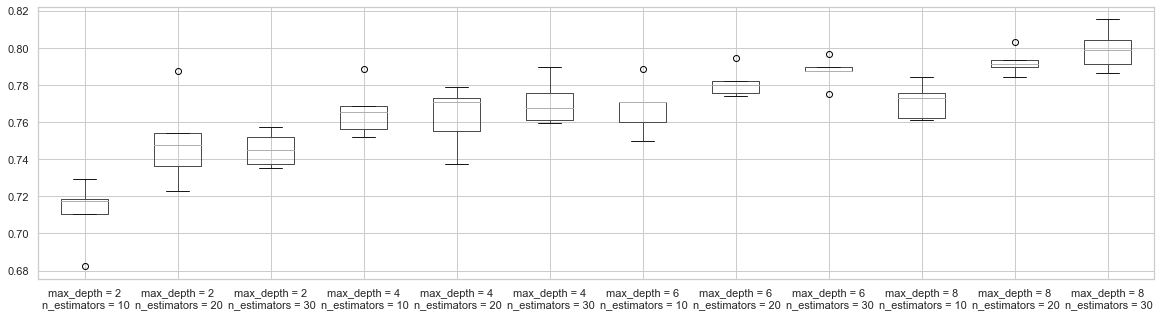

In [73]:
RF_params = RF_cv_restults['params']
RF_params_str = []
RF_fold_0_result = RF_cv_restults['split0_test_score']
RF_fold_1_result = RF_cv_restults['split1_test_score']
RF_fold_2_result = RF_cv_restults['split2_test_score']
RF_fold_3_result = RF_cv_restults['split3_test_score']
RF_fold_4_result = RF_cv_restults['split4_test_score']

RF_para_k_fold_list = []
RF_para_k_fold_list.append(RF_fold_0_result)
RF_para_k_fold_list.append(RF_fold_1_result)
RF_para_k_fold_list.append(RF_fold_2_result)
RF_para_k_fold_list.append(RF_fold_3_result)
RF_para_k_fold_list.append(RF_fold_4_result)
for i in range(len(RF_params)):
    RF_params_str.append("max_depth = "+ str(RF_params[i]['rf__max_depth']) +"\n n_estimators = "+ str(RF_params[i]['rf__n_estimators']))
    
RF_para_k_fold_list_df = pd.DataFrame(RF_para_k_fold_list, columns = RF_params_str)
RF_para_k_fold_list_df.boxplot(figsize = (20,5))
plt.plot()

# Evaluation

In [74]:
def evaluate_model(y_test, y_pred):
    accuracy =accuracy_score(y_test, y_pred)  
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

x_test_ml_copy = x_test_ml.drop(['GENDER','ETHNICITY'],axis = 1)
RF_best_model = RF_best_model
y_pred_ml = RF_best_model.predict(x_test_ml_copy)
y_pred_pro_ml = RF_best_model.predict_proba(x_test_ml_copy)

y_pre_proba = model.predict([x_test_1, x_test_2_copy])
y_pred = np.round(y_pre_proba).astype(int)
y_pred = y_pred.flatten()
# accuracy =accuracy_score(y_test, y_pred)#np.mean(y_pred == y_test) * 100
# print(accuracy)

RF_accuracy, RF_precision, RF_recall, RF_f1_score = evaluate_model(y_test_ml, y_pred_ml)
DL_accuracy, DL_precision, DL_recall, DL_f1_score = evaluate_model(y_test, y_pred)

38/38 [==============================] - 4s 90ms/step


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\4217730848.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


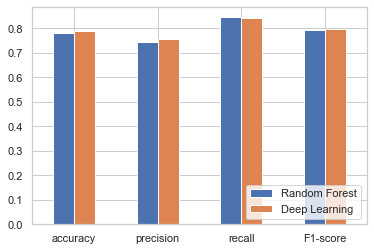

In [75]:
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
DL_metrics = np.array([DL_accuracy, DL_precision, DL_recall, DL_f1_score])

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics,
                           'Deep Learning': DL_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [76]:
dl_fpr, dl_tpr, dl_thresholds = roc_curve(y_test, y_pre_proba, pos_label = 1)

f_c_y_pred_pro_ml = [row[1] for row in y_pred_pro_ml]
ml_fpr, ml_tpr, ml_thresholds = roc_curve(y_test_ml, f_c_y_pred_pro_ml, pos_label = 1)

dl_auc = auc(dl_fpr, dl_tpr)
ml_auc = auc(ml_fpr, ml_tpr)

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3173904988.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


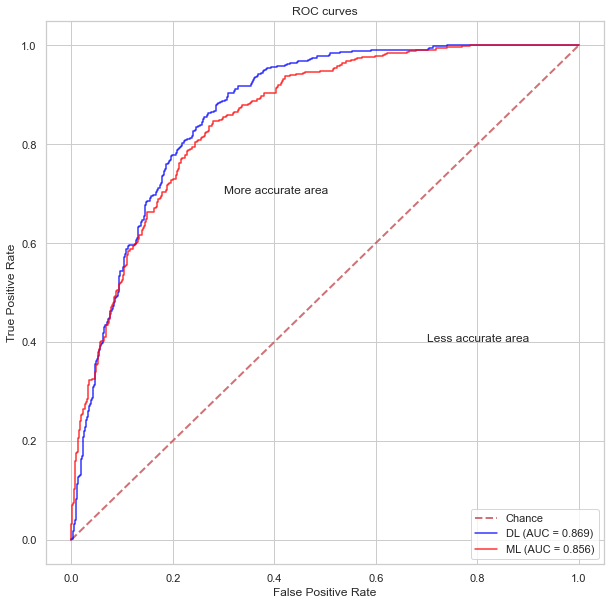

In [77]:
plt.figure(figsize = (10,10) )

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(dl_fpr, dl_tpr,  color='blue', label='DL (AUC = {:.3f})'.format(dl_auc), alpha=0.8)#label
plt.plot(ml_fpr, ml_tpr,  color='red', label='ML (AUC = {:.3f})'.format(ml_auc), alpha=0.8)  #label=' (Cnn_AUC = {:.3f})'.format(cnn_auc)
plt.text(0.3,0.7,'More accurate area',fontsize = 12)
plt.text(0.7,0.4,'Less accurate area',fontsize = 12)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

# Fairness 

In [78]:
def createFairnessMetrics(y_test, y_pred, x_test, protect_feature_name, target_group, reference_group):
    
    mf = MetricFrame(metrics={"fnr":false_negative_rate, "tpr":true_positive_rate,"fpr":false_positive_rate,
                           "tnr":true_negative_rate,"sel":selection_rate, "acc":accuracy_score},
                  y_true=y_test,
                  y_pred=y_pred,
                  sensitive_features=x_test[[protect_feature_name]])

    dpd = abs(mf.by_group['sel'][target_group] - mf.by_group['sel'][reference_group]) 
    
    if mf.by_group['sel'][reference_group] == 0:
        mf.by_group['sel'][reference_group] = 0.1
    
    a = max(mf.by_group['sel'][target_group], mf.by_group['sel'][reference_group])
    b = min(mf.by_group['sel'][target_group], mf.by_group['sel'][reference_group])
    dpa = b / a
    
    if mf.by_group['tpr'][reference_group] == 0:
        mf.by_group['tpr'][reference_group] = 0.1
        
    if mf.by_group['fpr'][reference_group] == 0:
        mf.by_group['fpr'][reference_group] = 0.1
    

    eod = max(abs(mf.by_group['tpr'][target_group] - mf.by_group['tpr'][reference_group])
              , abs(mf.by_group['fpr'][target_group] - mf.by_group['fpr'][reference_group]) )
    
    a = max(mf.by_group['tpr'][target_group], mf.by_group['tpr'][reference_group])
    b = min(mf.by_group['tpr'][target_group], mf.by_group['tpr'][reference_group])
    c= max(mf.by_group['fpr'][target_group], mf.by_group['fpr'][reference_group])
    d = min(mf.by_group['fpr'][target_group], mf.by_group['fpr'][reference_group])

    eor = min(b / a
              ,d / c )

    ad = abs(mf.by_group['acc'][target_group] - mf.by_group['acc'][reference_group])
    
    if mf.by_group['acc'][reference_group] == 0:
        mf.by_group['acc'][reference_group] = 0.1
        
    a = max(mf.by_group['acc'][target_group], mf.by_group['acc'][reference_group])
    b = min(mf.by_group['acc'][target_group], mf.by_group['acc'][reference_group])    
    ar = b / a 
    
    fairness_metrics = np.array([dpd,dpa,eod,eor,ad,ar])
    index = ['Demographic Parity difference', 'Demographic Parity Ratio', 'Equalized Odds difference', 'Equalized Odds Ratio', 'Equal Accuracy difference', 'Equal Accuracy Ratio']
    dataframe = pd.DataFrame({target_group: fairness_metrics}, index=index)
    return dataframe
    

In [79]:
#deep learning fair metrics 

mf1 = MetricFrame(metrics={"fnr":false_negative_rate, "tpr":true_positive_rate,"fpr":false_positive_rate,
                           "tnr":true_negative_rate,"sel":selection_rate, "acc":accuracy_score},
                  y_true=y_test,
                  y_pred=y_pred,
                  sensitive_features=x_test_2[['ETHNICITY']])

mf1.by_group

,fnr,tpr,fpr,tnr,sel,acc
ETHNICITY,,,,,,
ASIAN,0.000000,1.000000,0.208333,0.791667,0.424242,0.848485
BLACK,0.250000,0.750000,0.285714,0.714286,0.454545,0.727273
HISPANIC/LATINO,0.000000,1.000000,0.208333,0.791667,0.500000,0.868421
NOT INFORMED,0.150442,0.849558,0.234694,0.765306,0.563981,0.810427
OTHERS,0.076923,0.923077,0.130435,0.869565,0.416667,0.888889
WHITE,0.167082,0.832918,0.272251,0.727749,0.559387,0.781609


deep learning fairness scores
                                 Female
Demographic Parity difference  0.069820
Demographic Parity Ratio       0.879441
Equalized Odds difference      0.063511
Equalized Odds Ratio           0.796925
Equal Accuracy difference      0.002547
Equal Accuracy Ratio           0.996781
                                  ASIAN     BLACK  HISPANIC/LATINO  \
Demographic Parity difference  0.135145  0.104842         0.059387   
Demographic Parity Ratio       0.758406  0.812578         0.893836   
Equalized Odds difference      0.167082  0.082918         0.167082   
Equalized Odds Ratio           0.765224  0.900449         0.765224   
Equal Accuracy difference      0.066876  0.054336         0.086812   
Equal Accuracy Ratio           0.921182  0.930481         0.900035   

                               NOT INFORMED    OTHERS  
Demographic Parity difference      0.004594  0.142720  
Demographic Parity Ratio           0.991854  0.744863  
Equalized Odds difference      

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3272489608.py:43: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


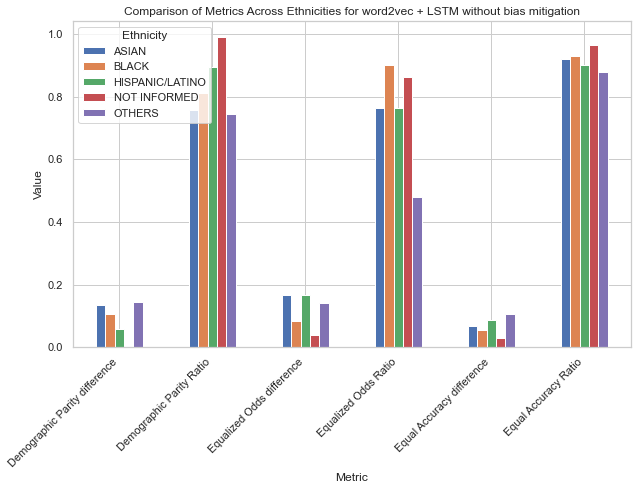

In [88]:
print("deep learning fairness scores")
data_fairness_metrix_gender_dp = createFairnessMetrics(y_test, y_pred, x_test_2, 'GENDER','F','M')
# print(data_fairness_metrix_gender,'\n')
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test, y_pred, x_test_2, 'ETHNICITY','ASIAN','WHITE')
# print('ASIAN')
# print(data_fairness_metrix_ethnicity_a,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test, y_pred, x_test_2, 'ETHNICITY','BLACK','WHITE')
# print('BLACK')
# print(data_fairness_metrix_ethnicity_b,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test, y_pred, x_test_2, 'ETHNICITY','HISPANIC/LATINO','WHITE')
# print('HISPANIC/LATINO')
# print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test, y_pred, x_test_2, 'ETHNICITY','NOT INFORMED','WHITE')
# print('NOT INFORMED')
# print(data_fairness_metrix_ethnicity_n,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test, y_pred, x_test_2, 'ETHNICITY','OTHERS','WHITE')
# print('OTHERS')
# print(data_fairness_metrix_ethnicity_o,'\n')


new_column_names = {'F':'Female'}
data_fairness_metrix_gender_dp.rename(columns=new_column_names, inplace=True)
print(data_fairness_metrix_gender_dp)

data_fairness_metrix_ethnicity_merge_dp = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_merge_dp.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_merge_dp.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_merge_dp.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_merge_dp.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])

print(data_fairness_metrix_ethnicity_merge_dp)

data_fairness_metrix_ethnicity_merge_dp.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of Metrics Across Ethnicities for word2vec + LSTM without bias mitigation')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ethnicity')
plt.show()

In [82]:
data_fairness_metrix_gender_dp

,Female
Demographic Parity difference,0.069820
Demographic Parity Ratio,0.879441
Equalized Odds difference,0.063511
Equalized Odds Ratio,0.796925
Equal Accuracy difference,0.002547
Equal Accuracy Ratio,0.996781


machine learning (random forest) fairness scores
                                 Female
Demographic Parity difference  0.069820
Demographic Parity Ratio       0.879441
Equalized Odds difference      0.063511
Equalized Odds Ratio           0.796925
Equal Accuracy difference      0.002547
Equal Accuracy Ratio           0.996781 

ASIAN
                                 OTHERS
Demographic Parity difference  0.188378
Demographic Parity Ratio       0.673673
Equalized Odds difference      0.111427
Equalized Odds Ratio           0.609493
Equal Accuracy difference      0.018838
Equal Accuracy Ratio           0.976615 

BLACK
                                 OTHERS
Demographic Parity difference  0.188378
Demographic Parity Ratio       0.673673
Equalized Odds difference      0.111427
Equalized Odds Ratio           0.609493
Equal Accuracy difference      0.018838
Equal Accuracy Ratio           0.976615 

HISPANIC/LATINO
                                 OTHERS
Demographic Parity difference  0.1883

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2356353114.py:52: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


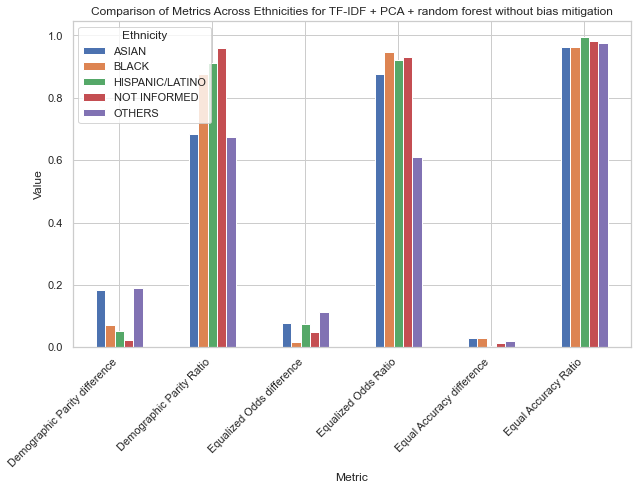

In [90]:
#machine learning fair metrics 

mf2 = MetricFrame(metrics={"fnr":false_negative_rate, "tpr":true_positive_rate,"fpr":false_positive_rate,
                           "tnr":true_negative_rate,"sel":selection_rate, "acc":accuracy_score},
                  y_true=y_test_ml,
                  y_pred=y_pred_ml,
                  sensitive_features=x_test_ml[['ETHNICITY']])

mf2.by_group  

print("machine learning (random forest) fairness scores")
data_fairness_metrix_gender_rf = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'GENDER','F','M')
print(data_fairness_metrix_gender,'\n')
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','ASIAN','WHITE')
print('ASIAN')
print(data_fairness_metrix_ethnicity,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','BLACK','WHITE')
print('BLACK')
print(data_fairness_metrix_ethnicity,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','HISPANIC/LATINO','WHITE')
print('HISPANIC/LATINO')
print(data_fairness_metrix_ethnicity,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','NOT INFORMED','WHITE')
print('NOT INFORMED')
print(data_fairness_metrix_ethnicity,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','OTHERS','WHITE')
print('OTHERS')
print(data_fairness_metrix_ethnicity,'\n')

new_column_names = {'F':'Female'}
data_fairness_metrix_gender_rf.rename(columns=new_column_names, inplace=True)
print(data_fairness_metrix_gender_rf)

data_fairness_metrix_ethnicity_merge_rf = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_merge_rf.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_merge_rf.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_merge_rf.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_merge_rf.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])

print(data_fairness_metrix_ethnicity_merge_rf)

data_fairness_metrix_ethnicity_merge_rf.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Comparison of Metrics Across Ethnicities for TF-IDF + PCA + random forest without bias mitigation')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ethnicity')
plt.show()

In [87]:
data_fairness_metrix_gender_rf

,Female
Demographic Parity difference,0.051678
Demographic Parity Ratio,0.911318
Equalized Odds difference,0.046086
Equalized Odds Ratio,0.848186
Equal Accuracy difference,0.002033
Equal Accuracy Ratio,0.997402


# Fairness mitigation

Fairness mitigation for deep learning

In [32]:
#the codes below use to check whether these two models' parameters are the same
# layer = model.get_layer('bidirectional')
# layer_weights = layer.get_weights()
# print(layer_weights)
# layer1 = intermediate_model.get_layer('bidirectional')
# layer1_weights = layer1.get_weights()
# print(layer1_weights)


input_df = df_merge_w2v.drop(['MARITAL_STATUS','RELIGION','ADMISSION_TYPE','INSURANCE','HADM_ID','SUBJECT_ID','CATEGORY','ISERROR','TEXT'],axis = 1)
y = input_df.HOSPITAL_EXPIRE_FLAG
x = input_df.drop('HOSPITAL_EXPIRE_FLAG',axis = 1)
y = y.astype(int)#convert the float type into integer

#let the intermediate to inherit the parameters of the model, and leverage it to get the pre-trained input for 
#mitigating the unfairness
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)
intermediate_model.summary()
F1_index = x.columns.get_loc('F1')
x_1 = x.iloc[:, F1_index:]#for deep learning
x_2 = x.iloc[:,:F1_index]
x_eth = x['ETHNICITY']#this will be used when concatenating this feature and the transformed table
x_gen = x['GENDER']
x_2 = x_2.drop(['ETHNICITY','GENDER'],axis = 1)
concatenate_output = intermediate_model.predict([x_1,x_2])

concatenate_output_df = pd.DataFrame(concatenate_output)
combined_data = pd.concat([x_eth, concatenate_output_df], axis=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 50)      573350      ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          183296      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                            

In [33]:
#the reason of mapping is used to conduct the correlation remover because correclation remover need numeric features
#instead of string features

#map the entnicity
mapper_ethnicity={
    'WHITE':0,
    'NOT INFORMED':1,
    'BLACK':2,
    'ASIAN':3,
    'HISPANIC/LATINO':4,
    'OTHERS':5

}

combined_data['ETHNICITY'] = combined_data['ETHNICITY'].replace(mapper_ethnicity)

# the second model
def build_new_rnn_model(shape: int):
    
    input_1= Input(shape=(shape))
    Dropout_layer_1 = Dropout(0.25)(input_1)
    Dense_layer = Dense(64)(Dropout_layer_1)
    Droupout_layer_2 = Dropout(0.3)(Dense_layer)
    output_layer = Dense(1, activation='sigmoid')(Droupout_layer_2)
    model=Model([input_1], output_layer)
    return model

COMPARE WITH THE MODEL WITHOUT MITIGATION

In [34]:
# COMPARE WITH THE MODEL WITHOUT MITIGATION
x_train, x_test, y_train, y_test = model_selection.train_test_split(combined_data, y,test_size=0.2, random_state = 5)
x_train = x_train.drop(["ETHNICITY"], axis = 1)
c_t_x, c_v_x, c_t_y, c_v_y = model_selection.train_test_split(x_train, y_train,test_size=0.2, random_state = 1)

new_model = build_new_rnn_model(shape = combined_data.shape[1] - 1) 
new_model.summary()    
new_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

new_model.fit(
    x = c_t_x,
    y = c_t_y,
    validation_data=(c_v_x, c_v_y),
    batch_size=100,
    epochs = 10)

x_test_copy = x_test.drop(['ETHNICITY'],axis = 1)

#predict it
y_pre_proba = new_model.predict(x_test_copy)
y_pred = np.round(y_pre_proba).astype(int)
y_pred = y_pred.flatten()

DL_noMi_accuracy, DL_noMi_precision, DL_noMi_recall, DL_noMi_f1_score = evaluate_model(y_test, y_pred)
print(DL_noMi_accuracy)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 274)]             0         
                                                                 
 dropout_2 (Dropout)         (None, 274)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                17600     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
39/39 [==============================] - 0s 

In [35]:
combined_data_merge_y = pd.concat([combined_data, y], axis=1)


binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=combined_data_merge_y,
    label_names=['HOSPITAL_EXPIRE_FLAG'],
    protected_attribute_names=['ETHNICITY'])


In [36]:
#mitigate the unfairness using DisparateImpact remover for deep learning
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed_di = dataset_transf_train.convert_to_dataframe()[0]
transformed_di = transformed_di.drop(["HOSPITAL_EXPIRE_FLAG"], axis = 1)

#split the data into train, validate and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(transformed_di, y,test_size=0.2, random_state = 5)
x_train = x_train.drop(["ETHNICITY"], axis = 1)
c_t_x, c_v_x, c_t_y, c_v_y = model_selection.train_test_split(x_train, y_train,test_size=0.2, random_state = 1)

new_model = build_new_rnn_model(shape = transformed_di.shape[1] - 1) 
new_model.summary()    
new_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

new_model.fit(
    x = c_t_x,
    y = c_t_y,
    validation_data=(c_v_x, c_v_y),
    batch_size=100,
    epochs = 10)

x_test_copy = x_test.drop(['ETHNICITY'],axis = 1)

#predict it
y_pre_proba = new_model.predict(x_test_copy)
y_pred = np.round(y_pre_proba).astype(int)
y_pred = y_pred.flatten()

DL_DI_accuracy, DL_DI_precision, DL_DI_recall, DL_DI_f1_score = evaluate_model(y_test, y_pred)
print(DL_DI_accuracy)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 274)]             0         
                                                                 
 dropout_4 (Dropout)         (None, 274)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                17600     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
39/39 [==============================] - 0s 

In [37]:
mapper_ethnicity={
    0:'WHITE',
    1:'NOT INFORMED',
    2:'BLACK',
    3:'ASIAN',
    4:'HISPANIC/LATINO',
    5:'OTHERS'

}

x_test['ETHNICITY'] = x_test['ETHNICITY'].replace(mapper_ethnicity)

print("DisparateImpact remover")
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','ASIAN','WHITE')
print('ASIAN')
print(data_fairness_metrix_ethnicity_a,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','BLACK','WHITE')
print('BLACK')
print(data_fairness_metrix_ethnicity_b,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','HISPANIC/LATINO','WHITE')
print('HISPANIC/LATINO')
print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','NOT INFORMED','WHITE')
print('NOT INFORMED')
print(data_fairness_metrix_ethnicity_n,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','OTHERS','WHITE')
print('OTHERS')
print(data_fairness_metrix_ethnicity_o,'\n')



DisparateImpact remover
ASIAN
                                  ASIAN
Demographic Parity difference  0.153626
Demographic Parity Ratio       0.716826
Equalized Odds difference      0.101468
Equalized Odds Ratio           0.611930
Equal Accuracy difference      0.069494
Equal Accuracy Ratio           0.919297 

BLACK
                                  BLACK
Demographic Parity difference  0.011940
Demographic Parity Ratio       0.978464
Equalized Odds difference      0.103611
Equalized Odds Ratio           0.716195
Equal Accuracy difference      0.068844
Equal Accuracy Ratio           0.913033 

HISPANIC/LATINO
                               HISPANIC/LATINO
Demographic Parity difference         0.038130
Demographic Parity Ratio              0.934331
Equalized Odds difference             0.150376
Equalized Odds Ratio                  0.639144
Equal Accuracy difference             0.081939
Equal Accuracy Ratio                  0.896491 

NOT INFORMED
                               NOT INFOR

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2743501324.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


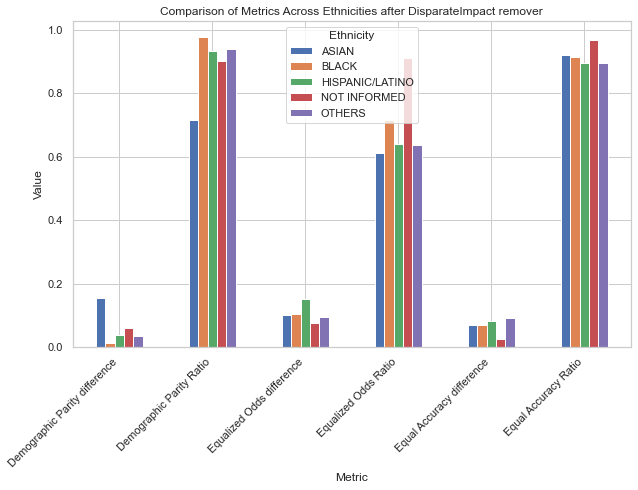

In [38]:
data_fairness_metrix_ethnicity_dp_di_merge = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_dp_di_merge.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_dp_di_merge.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_dp_di_merge.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_dp_di_merge.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])


In [39]:
#mitigate the unfairness using correlation remover for deep learning
cr = CorrelationRemover(sensitive_feature_ids=['ETHNICITY'])
cr.fit(combined_data)
combined_data_transform = cr.transform(combined_data)


# maybe the codes below can be used to plot the heat map to show the correlation between each features and ethnicity

feature_names = combined_data.columns
feature_names_drop = feature_names.drop(['ETHNICITY'])
combined_data_transform_df = pd.DataFrame(
    combined_data_transform, columns = feature_names_drop
)
combined_data_transform_df["ETHNICITY"] = x_eth


#split the data into train, validate and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(combined_data_transform_df, y,test_size=0.2, random_state = 5)
x_train = x_train.drop(["ETHNICITY"], axis = 1)
c_t_x, c_v_x, c_t_y, c_v_y = model_selection.train_test_split(x_train, y_train,test_size=0.2, random_state = 1)

new_model = build_new_rnn_model(shape = combined_data_transform.shape[1]) 
new_model.summary()    
new_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

new_model.fit(
    x = c_t_x,
    y = c_t_y,
    validation_data=(c_v_x, c_v_y),
    batch_size=100,
    epochs = 10)

x_test_copy = x_test.drop(['ETHNICITY'],axis = 1)

#predict it
y_pre_proba = new_model.predict(x_test_copy)
y_pred = np.round(y_pre_proba).astype(int)
y_pred = y_pred.flatten()

DL_CR_accuracy, DL_CR_precision, DL_CR_recall, DL_f1_CR_score = evaluate_model(y_test, y_pred)
print(DL_CR_accuracy)


Model: "model_4"


D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 274)]             0         
                                                                 
 dropout_6 (Dropout)         (None, 274)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                17600     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
39/39 [==============================] - 0s 4ms/step - loss: 

In [40]:
print("correlation remover")
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','ASIAN','WHITE')
print('ASIAN')
print(data_fairness_metrix_ethnicity_a,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','BLACK','WHITE')
print('BLACK')
print(data_fairness_metrix_ethnicity_b,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','HISPANIC/LATINO','WHITE')
print('HISPANIC/LATINO')
print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','NOT INFORMED','WHITE')
print('NOT INFORMED')
print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test, y_pred, x_test, 'ETHNICITY','OTHERS','WHITE')
print('OTHERS')
print(data_fairness_metrix_ethnicity_o,'\n')

correlation remover
ASIAN
                                  ASIAN
Demographic Parity difference  0.138290
Demographic Parity Ratio       0.723088
Equalized Odds difference      0.099567
Equalized Odds Ratio           0.556596
Equal Accuracy difference      0.092482
Equal Accuracy Ratio           0.895958 

BLACK
                                  BLACK
Demographic Parity difference  0.045153
Demographic Parity Ratio       0.917082
Equalized Odds difference      0.133610
Equalized Odds Ratio           0.617389
Equal Accuracy difference      0.063734
Equal Accuracy Ratio           0.919973 

HISPANIC/LATINO
                               HISPANIC/LATINO
Demographic Parity difference         0.048986
Demographic Parity Ratio              0.910673
Equalized Odds difference             0.190476
Equalized Odds Ratio                  0.592890
Equal Accuracy difference             0.054472
Equal Accuracy Ratio                  0.931603 

NOT INFORMED
                               HISPANIC/LATI

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2386896619.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


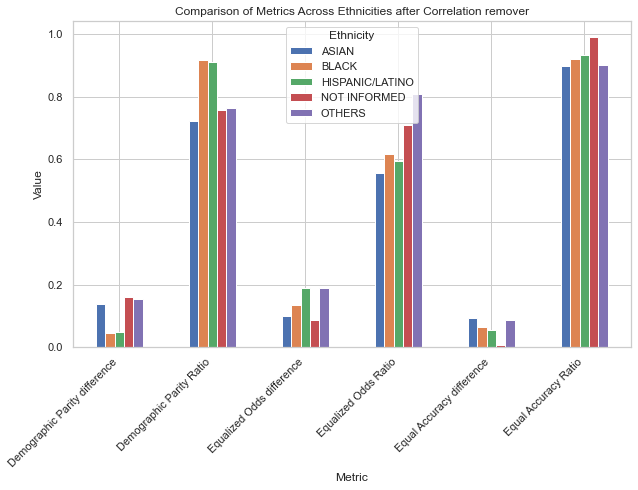

In [41]:
data_fairness_metrix_ethnicity_dp_cr_merge = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_dp_cr_merge.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_dp_cr_merge.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_dp_cr_merge.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_dp_cr_merge.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3087046566.py:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


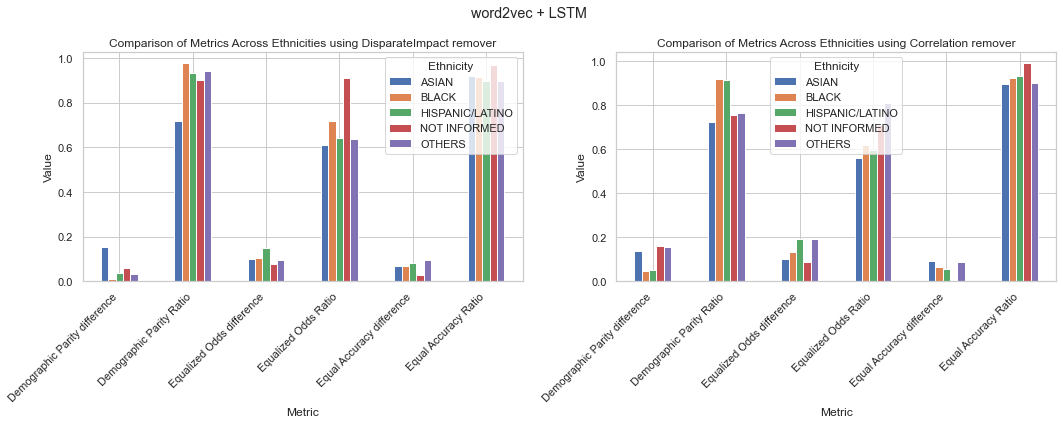

In [97]:


# Assuming you have the data_fairness_metrix_ethnicity_dp_di_merge and data_fairness_metrix_ethnicity_dp_cr_merge DataFrames

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first figure on the left subplot
data_fairness_metrix_ethnicity_dp_di_merge.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Metric')
axs[0].set_ylabel('Value')
axs[0].set_title('Comparison of Metrics Across Ethnicities using DisparateImpact remover')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(title='Ethnicity')

# Plot the second figure on the right subplot
data_fairness_metrix_ethnicity_dp_cr_merge.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Metric')
axs[1].set_ylabel('Value')
axs[1].set_title('Comparison of Metrics Across Ethnicities using Correlation remover')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(title='Ethnicity')

# Set a main title for the merged figure
plt.suptitle('word2vec + LSTM')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the merged plot
plt.show()


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2822898871.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


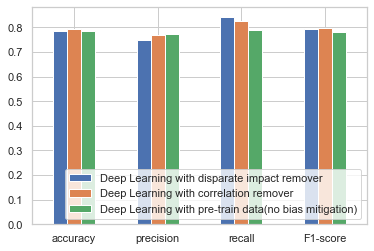

In [42]:
DL_DI_metrics = DL_DI_accuracy, DL_DI_precision, DL_DI_recall, DL_DI_f1_score
DL_CR_metrics = DL_CR_accuracy, DL_CR_precision, DL_CR_recall, DL_f1_CR_score
DL_noMi_metrics = DL_noMi_accuracy, DL_noMi_precision, DL_noMi_recall, DL_noMi_f1_score

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'Deep Learning with disparate impact remover': DL_DI_metrics,
                           'Deep Learning with correlation remover': DL_CR_metrics,
                           'Deep Learning with pre-train data(no bias mitigation)': DL_noMi_metrics,}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Fairness mitigation for machine learning

In [43]:
input_df = df_tfidf_merge.drop(['GENDER','MARITAL_STATUS','RELIGION','ADMISSION_TYPE','INSURANCE','HADM_ID','SUBJECT_ID','CATEGORY','ISERROR','TEXT'],axis = 1)

yy = input_df.HOSPITAL_EXPIRE_FLAG
xx = input_df.drop(['HOSPITAL_EXPIRE_FLAG'],axis = 1)
yy= y.astype(int)#convert the float type into integer

xx_eth = xx['ETHNICITY']#this will be used when concatenating this feature and the transformed table

In [44]:
mapper_ethnicity={
    'WHITE':0,
    'NOT INFORMED':1,
    'BLACK':2,
    'ASIAN':3,
    'HISPANIC/LATINO':4,
    'OTHERS':5

    
}
xx = xx.replace(mapper_ethnicity)

xx_merge_yy = pd.concat([xx,yy],axis = 1)
binaryLabelDataset_2 = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=xx_merge_yy,
    label_names=['HOSPITAL_EXPIRE_FLAG'],
    protected_attribute_names=['ETHNICITY'])

disparate impact remover

rf


[]

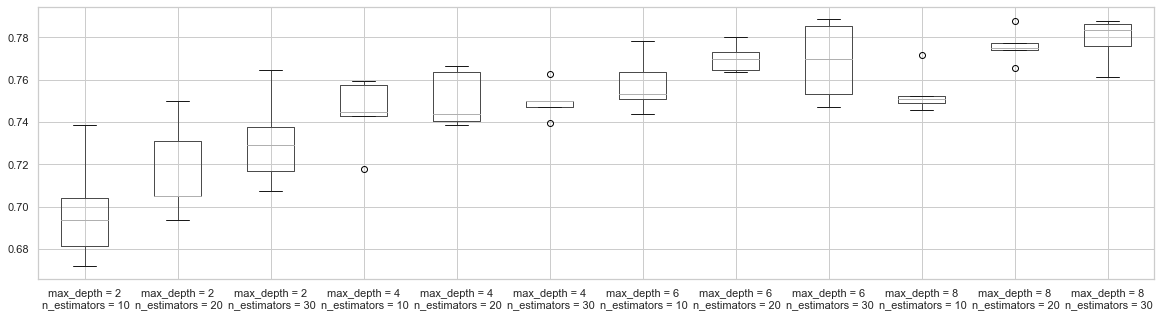

In [45]:
#mitigate the unfairness using DisparateImpact remover for deep learning
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset_2)
transformed_di = dataset_transf_train.convert_to_dataframe()[0]

y = transformed_di.HOSPITAL_EXPIRE_FLAG
x = transformed_di.drop(['HOSPITAL_EXPIRE_FLAG'],axis = 1)
y = y.astype(int)#convert the float type into integer
x_train_ml, x_test_ml, y_train_ml, y_test_ml = model_selection.train_test_split(x, y,test_size=0.2, random_state = 5)
x_train_ml = x_train_ml.drop(['ETHNICITY'],axis = 1)
RF_best_params_di, RF_best_model_di, RF_best_score_di, RF_cv_restults_di = ML(x_train_ml, y_train_ml, 'rf', RandomForestClassifier(), RF_param_grid )

RF_params = RF_cv_restults['params']
RF_params_str = []
RF_fold_0_result = RF_cv_restults_di['split0_test_score']
RF_fold_1_result = RF_cv_restults_di['split1_test_score']
RF_fold_2_result = RF_cv_restults_di['split2_test_score']
RF_fold_3_result = RF_cv_restults_di['split3_test_score']
RF_fold_4_result = RF_cv_restults_di['split4_test_score']

RF_para_k_fold_list_di = []
RF_para_k_fold_list_di.append(RF_fold_0_result)
RF_para_k_fold_list_di.append(RF_fold_1_result)
RF_para_k_fold_list_di.append(RF_fold_2_result)
RF_para_k_fold_list_di.append(RF_fold_3_result)
RF_para_k_fold_list_di.append(RF_fold_4_result)
for i in range(len(RF_params)):
    RF_params_str.append("max_depth = "+ str(RF_params[i]['rf__max_depth']) +"\n n_estimators = "+ str(RF_params[i]['rf__n_estimators']))
    
RF_para_k_fold_list_df_di = pd.DataFrame(RF_para_k_fold_list_di, columns = RF_params_str)
RF_para_k_fold_list_df_di.boxplot(figsize = (20,5))
plt.plot()

DisparateImpact remover for random forest
ASIAN
                                  ASIAN
Demographic Parity difference  0.271457
Demographic Parity Ratio       0.551155
Equalized Odds difference      0.268624
Equalized Odds Ratio           0.229474
Equal Accuracy difference      0.153792
Equal Accuracy Ratio           0.832226 

BLACK
                                  BLACK
Demographic Parity difference  0.089939
Demographic Parity Ratio       0.851289
Equalized Odds difference      0.042607
Equalized Odds Ratio           0.910610
Equal Accuracy difference      0.020300
Equal Accuracy Ratio           0.973390 

HISPANIC/LATINO
                               HISPANIC/LATINO
Demographic Parity difference         0.056403
Demographic Parity Ratio              0.906739
Equalized Odds difference             0.115288
Equalized Odds Ratio                  0.884712
Equal Accuracy difference             0.020939
Equal Accuracy Ratio                  0.972553 

NOT INFORMED
                      

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\2454251267.py:52: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


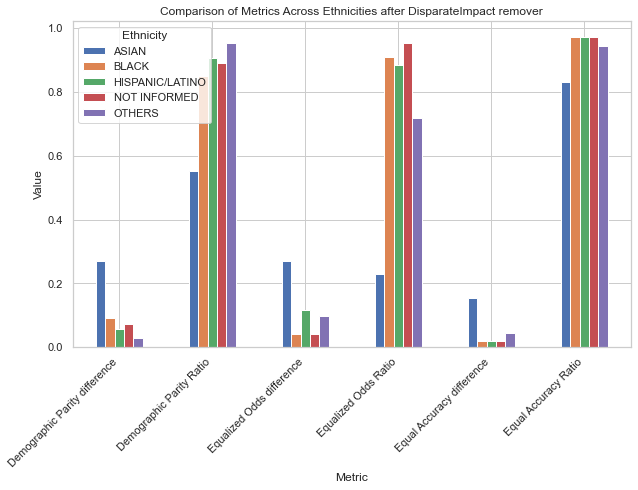

In [46]:
x_test_ml_copy = x_test_ml.drop(['ETHNICITY'],axis = 1)
y_pred_ml = RF_best_model_di.predict(x_test_ml_copy)
RF_accuracy_di, RF_precision_di, RF_recall_di, RF_f1_score_di = evaluate_model(y_test_ml, y_pred_ml)

mapper_ethnicity={
    0:'WHITE',
    1:'NOT INFORMED',
    2:'BLACK',
    3:'ASIAN',
    4:'HISPANIC/LATINO',
    5:'OTHERS'

}

x_test_ml['ETHNICITY'] = x_test_ml['ETHNICITY'].replace(mapper_ethnicity)

print("DisparateImpact remover for random forest")
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','ASIAN','WHITE')
print('ASIAN')
print(data_fairness_metrix_ethnicity_a,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','BLACK','WHITE')
print('BLACK')
print(data_fairness_metrix_ethnicity_b,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','HISPANIC/LATINO','WHITE')
print('HISPANIC/LATINO')
print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','NOT INFORMED','WHITE')
print('NOT INFORMED')
print(data_fairness_metrix_ethnicity_n,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','OTHERS','WHITE')
print('OTHERS')
print(data_fairness_metrix_ethnicity_o,'\n')

data_fairness_metrix_ethnicity_rf_di_merge = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_rf_di_merge.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_rf_di_merge.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_rf_di_merge.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_rf_di_merge.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])

data_fairness_metrix_ethnicity_rf_di_merge


correlation remover

rf


[]

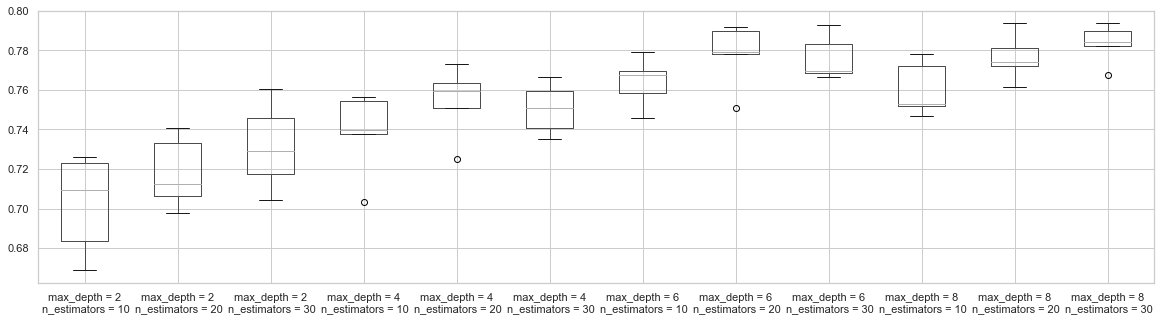

In [47]:
cr = CorrelationRemover(sensitive_feature_ids=['ETHNICITY'])
cr.fit(xx)
xx_transform = cr.transform(xx)

feature_names = xx.columns
feature_names_drop = feature_names.drop(['ETHNICITY'])
xx_transform_df = pd.DataFrame(
    xx_transform, columns = feature_names_drop
)
xx_transform_df["ETHNICITY"] = xx_eth

x_train_ml, x_test_ml, y_train_ml, y_test_ml = model_selection.train_test_split(xx_transform_df, yy,test_size=0.2, random_state = 5)
x_train_ml = x_train_ml.drop(["ETHNICITY"], axis = 1)

RF_best_params_cr, RF_best_model_cr, RF_best_score_cr, RF_cv_restults_cr = ML(x_train_ml, y_train_ml, 'rf', RandomForestClassifier(), RF_param_grid )

RF_params = RF_cv_restults['params']
RF_params_str = []
RF_fold_0_result = RF_cv_restults_cr['split0_test_score']
RF_fold_1_result = RF_cv_restults_cr['split1_test_score']
RF_fold_2_result = RF_cv_restults_cr['split2_test_score']
RF_fold_3_result = RF_cv_restults_cr['split3_test_score']
RF_fold_4_result = RF_cv_restults_cr['split4_test_score']

RF_para_k_fold_list_cr = []
RF_para_k_fold_list_cr.append(RF_fold_0_result)
RF_para_k_fold_list_cr.append(RF_fold_1_result)
RF_para_k_fold_list_cr.append(RF_fold_2_result)
RF_para_k_fold_list_cr.append(RF_fold_3_result)
RF_para_k_fold_list_cr.append(RF_fold_4_result)
for i in range(len(RF_params)):
    RF_params_str.append("max_depth = "+ str(RF_params[i]['rf__max_depth']) +"\n n_estimators = "+ str(RF_params[i]['rf__n_estimators']))
    
RF_para_k_fold_list_df_di = pd.DataFrame(RF_para_k_fold_list_cr, columns = RF_params_str)
RF_para_k_fold_list_df_di.boxplot(figsize = (20,5))
plt.plot()

DisparateImpact remover for random forest
ASIAN
                                  ASIAN
Demographic Parity difference  0.246075
Demographic Parity Ratio       0.594729
Equalized Odds difference      0.174983
Equalized Odds Ratio           0.593197
Equal Accuracy difference      0.000532
Equal Accuracy Ratio           0.999316 

BLACK
                                  BLACK
Demographic Parity difference  0.201245
Demographic Parity Ratio       0.668561
Equalized Odds difference      0.165414
Equalized Odds Ratio           0.612029
Equal Accuracy difference      0.004968
Equal Accuracy Ratio           0.993608 

HISPANIC/LATINO
                               HISPANIC/LATINO
Demographic Parity difference         0.155573
Demographic Parity Ratio              0.743781
Equalized Odds difference             0.124478
Equalized Odds Ratio                  0.862037
Equal Accuracy difference             0.067568
Equal Accuracy Ratio                  0.913067 

NOT INFORMED
                      

C:\Users\chen\AppData\Local\Temp\ipykernel_2760\3931079557.py:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


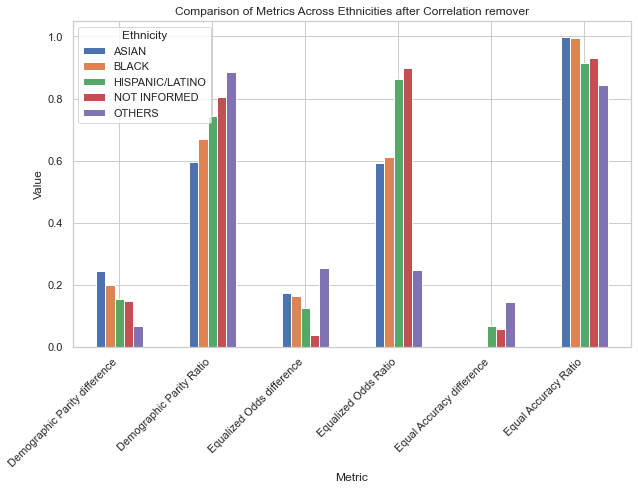

In [48]:
x_test_ml_copy = x_test_ml.drop(['ETHNICITY'],axis = 1)
y_pred_ml = RF_best_model_cr.predict(x_test_ml_copy)
RF_accuracy_cr, RF_precision_cr, RF_recall_cr, RF_f1_score_cr = evaluate_model(y_test_ml, y_pred_ml)

print("DisparateImpact remover for random forest")
data_fairness_metrix_ethnicity_a = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','ASIAN','WHITE')
print('ASIAN')
print(data_fairness_metrix_ethnicity_a,'\n')

data_fairness_metrix_ethnicity_b = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','BLACK','WHITE')
print('BLACK')
print(data_fairness_metrix_ethnicity_b,'\n')

data_fairness_metrix_ethnicity_h = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','HISPANIC/LATINO','WHITE')
print('HISPANIC/LATINO')
print(data_fairness_metrix_ethnicity_h,'\n')

data_fairness_metrix_ethnicity_n = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','NOT INFORMED','WHITE')
print('NOT INFORMED')
print(data_fairness_metrix_ethnicity_n,'\n')

data_fairness_metrix_ethnicity_o = createFairnessMetrics(y_test_ml, y_pred_ml, x_test_ml, 'ETHNICITY','OTHERS','WHITE')
print('OTHERS')
print(data_fairness_metrix_ethnicity_o,'\n')

data_fairness_metrix_ethnicity_rf_cr_merge = data_fairness_metrix_ethnicity_a.copy()
data_fairness_metrix_ethnicity_rf_cr_merge.insert(1, 'BLACK', data_fairness_metrix_ethnicity_b['BLACK'])
data_fairness_metrix_ethnicity_rf_cr_merge.insert(2, 'HISPANIC/LATINO', data_fairness_metrix_ethnicity_h['HISPANIC/LATINO'])
data_fairness_metrix_ethnicity_rf_cr_merge.insert(3, 'NOT INFORMED', data_fairness_metrix_ethnicity_n['NOT INFORMED'])
data_fairness_metrix_ethnicity_rf_cr_merge.insert(4, 'OTHERS', data_fairness_metrix_ethnicity_o['OTHERS'])


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\1539325217.py:26: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


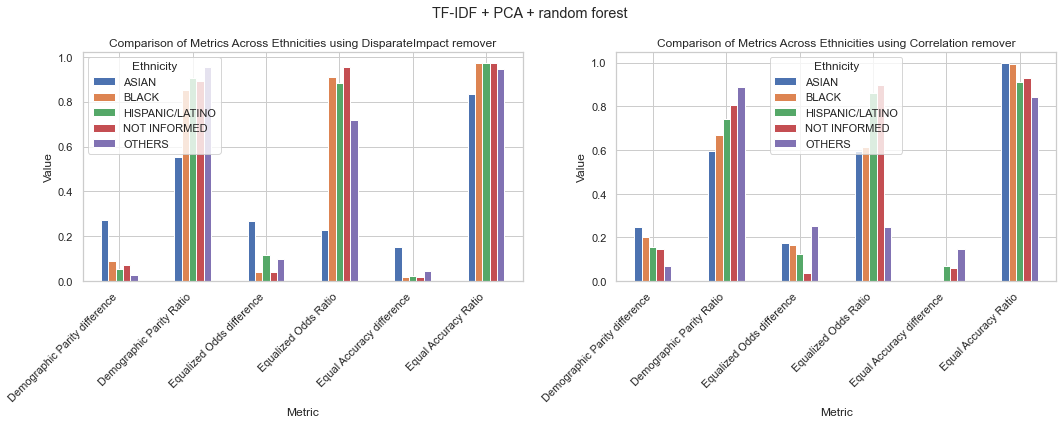

In [95]:
import matplotlib.pyplot as plt


# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first figure on the left subplot
data_fairness_metrix_ethnicity_rf_di_merge.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Metric')
axs[0].set_ylabel('Value')
axs[0].set_title('Comparison of Metrics Across Ethnicities using DisparateImpact remover')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(title='Ethnicity')

# Plot the second figure on the right subplot
data_fairness_metrix_ethnicity_rf_cr_merge.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Metric')
axs[1].set_ylabel('Value')
axs[1].set_title('Comparison of Metrics Across Ethnicities using Correlation remover')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(title='Ethnicity')

fig.suptitle('TF-IDF + PCA + random forest')
plt.tight_layout()

plt.show()


C:\Users\chen\AppData\Local\Temp\ipykernel_2760\1684244776.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


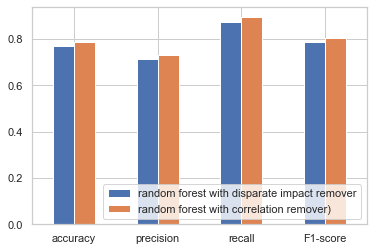

In [49]:

RF_di_metrics = RF_accuracy_di, RF_precision_di, RF_recall_di, RF_f1_score_di
RF_cr_metrics = RF_accuracy_cr, RF_precision_cr, RF_recall_cr, RF_f1_score_cr

index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'random forest with disparate impact remover': RF_di_metrics,
                           'random forest with correlation remover)': RF_cr_metrics,}
                          , index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [98]:
DL_DI_metrics = DL_DI_accuracy, DL_DI_precision, DL_DI_recall, DL_DI_f1_score
DL_CR_metrics = DL_CR_accuracy, DL_CR_precision, DL_CR_recall, DL_f1_CR_score
DL_noMi_metrics = DL_noMi_accuracy, DL_noMi_precision, DL_noMi_recall, DL_noMi_f1_score
RF_di_metrics = RF_accuracy_di, RF_precision_di, RF_recall_di, RF_f1_score_di
RF_cr_metrics = RF_accuracy_cr, RF_precision_cr, RF_recall_cr, RF_f1_score_cr
RF_metrics = RF_accuracy, RF_precision, RF_recall, RF_f1_score
DL_metrics = DL_accuracy, DL_precision, DL_recall, DL_f1_score

In [101]:
print(DL_DI_metrics)
print(DL_CR_metrics)
print(DL_noMi_metrics)
print(DL_metrics)
print(RF_di_metrics)
print(RF_cr_metrics)
print(RF_metrics)

(0.7841666666666667, 0.7481031866464339, 0.841296928327645, 0.7919678714859436)
(0.7933333333333333, 0.7674050632911392, 0.8276450511945392, 0.7963875205254516)
(0.7833333333333333, 0.7725752508361204, 0.78839590443686, 0.7804054054054054)
(0.79, 0.7569230769230769, 0.8395904436860068, 0.7961165048543689)
(0.7691666666666667, 0.7154811715481172, 0.8754266211604096, 0.7874136607828089)
(0.7866666666666666, 0.7298050139275766, 0.89419795221843, 0.8036809815950919)
(0.7816666666666666, 0.7432432432432432, 0.8447098976109215, 0.7907348242811502)
